## Data Preprocessing

## BERT Model 

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from tensorflow import keras
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
import os
import re
import pandas as pd
import numpy as np
print(tf.__version__)
df = pd.read_csv('F:\Files from Linux/cleaneddataset.csv')

C:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr

C:\Anaconda\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:544: FutureWarning: Passing (type, 1) or '1type' 

1.14.0


C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (35,36,37,38,39,41,42,43,47,48,49,51,60,61) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [3]:
# Run this cell for a function for oversampling

def oversample(X,y):
    # Get number of rows with imbalanced class
    target = y.sum().idxmax()
    n = y[target].sum()
    # identify imbalanced targets
    imbalanced = y.drop(target,axis=1)
    #For each target, create a dataframe of randomly sampled rows, append to list
    append_list =  [y.loc[y[col]==1].sample(n=n-y[col].sum(),replace=True,random_state=20) for col in imbalanced.columns]
    append_list.append(y)
    y = pd.concat(append_list,axis=0)
    # match y indexes on other inputs
    X = X.loc[y.index]
    assert (y.index.all() == X.index.all())
    return X, y

df = df.rename(columns = {"cleantext": "filtered_text"})
df = df.sort_values(by='release_date', ascending=True, axis=0)
testNum = int(len(df) * -.1)
X_train = df['filtered_text'][:testNum].dropna()
y_train = pd.get_dummies(columns=['target'],data=df['target'])[:testNum].dropna().iloc[:, :]
test = df.loc[list(set(list(df.index)) - set(list(X_train.index)))]
X_test = test['filtered_text'].dropna()
y_test = test['target'].dropna()

X_train, y_train = oversample(X_train, y_train)

# Recreate the target variable
y_train["target"] = np.nan

for i, y in y_train.iterrows():
    if str(type(y_train.loc[i])) == "<class 'pandas.core.frame.DataFrame'>": # If an index only has one observation, it draws up an error if we try to use the indexer agaon
        # They're usually classed as a series while the ones with many observations are considered a df. This is a way to get
        # rid of them
        if y_train.loc[i].iloc[0, 0] == 1:
            y_train.loc[i, "target"] = "Negative"
        elif y_train.loc[i].iloc[0, 1] == 1:
            y_train.loc[i, "target"] = "Neutral"
        else:
            y_train.loc[i, "target"] = "Positive"
    else: # If they only have one observation, we settle it here instead
        if y_train.loc[i][0] == 1:
              y_train.loc[i, "target"] = "Negative"
        elif y_train.loc[i][1] == 1:
            y_train.loc[i, "target"] = "Neutral"
        else:
            y_train.loc[i, "target"] = "Positive"
            
X_train2 = X_train.reset_index(drop = True)
y_train2 = y_train['target'].reset_index(drop = True)

data = pd.concat([X_train2, y_train2], axis = 1)
data.rename(columns = {"filtered_text":"doc"}, inplace = True)



X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)


#Added a random sample to make sure data is randomized going into BERT to help with overfitting
#as there are many negatives added at the front of the data in a row due to oversampling
train = data.sample(frac=1)



test = pd.concat([X_test, y_test], axis = 1) 
test.rename(columns = {"filtered_text":"doc"}, inplace = True)

In [6]:
print(len(y_train))

10071


# BERT Model

In [8]:
DATA_COLUMN = 'doc'
LABEL_COLUMN = 'target'
# label_list is the list of labels
label_list = ['Positive', 'Neutral', 'Negative']


train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)


BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

#BERT_MODEL_HUB = "https://tfhub.dev/google/albert_base/3"

def create_tokenizer_from_hub_module():
 # """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        bert_module = hub.Module(BERT_MODEL_HUB)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],tokenization_info["do_lower_case"]])
      
    return bert.tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 256


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [9]:
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 10071


INFO:tensorflow:Writing example 0 of 10071


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] january 25 , 2019 , the board approved and adopted effective immediately an amendment ( the “ amendment ” ) to the by ##law ##s of the company ( the “ by ##law ##s ” ) to remove the restriction in article ii , section 14 ( b ) ( xii ) that any shareholder nominee ( as defined in article ii , section 14 of the by ##law ##s ) who is included in the company ’ s proxy materials for a particular meeting of shareholders but does not receive at least twenty - five percent ( 25 % ) of the votes cast in favor of the shareholder nominee ’ s election , shall be ineligible to be a shareholder nominee pursuant to sub ##section ( b ) of section 14 of article ii of the by ##law ##s for the next two annual meetings of shareholders following the meeting for which the shareholder nominee has been included in the company ’ s proxy materials . the fore ##going description of the amendment does not pu ##rp ##ort to be complete and is qualified in its entirety by reference to t

INFO:tensorflow:tokens: [CLS] january 25 , 2019 , the board approved and adopted effective immediately an amendment ( the “ amendment ” ) to the by ##law ##s of the company ( the “ by ##law ##s ” ) to remove the restriction in article ii , section 14 ( b ) ( xii ) that any shareholder nominee ( as defined in article ii , section 14 of the by ##law ##s ) who is included in the company ’ s proxy materials for a particular meeting of shareholders but does not receive at least twenty - five percent ( 25 % ) of the votes cast in favor of the shareholder nominee ’ s election , shall be ineligible to be a shareholder nominee pursuant to sub ##section ( b ) of section 14 of article ii of the by ##law ##s for the next two annual meetings of shareholders following the meeting for which the shareholder nominee has been included in the company ’ s proxy materials . the fore ##going description of the amendment does not pu ##rp ##ort to be complete and is qualified in its entirety by reference to t

INFO:tensorflow:input_ids: 101 2254 2423 1010 10476 1010 1996 2604 4844 1998 4233 4621 3202 2019 7450 1006 1996 1523 7450 1524 1007 2000 1996 2011 14919 2015 1997 1996 2194 1006 1996 1523 2011 14919 2015 1524 1007 2000 6366 1996 16840 1999 3720 2462 1010 2930 2403 1006 1038 1007 1006 14371 1007 2008 2151 18668 9773 1006 2004 4225 1999 3720 2462 1010 2930 2403 1997 1996 2011 14919 2015 1007 2040 2003 2443 1999 1996 2194 1521 1055 24540 4475 2005 1037 3327 3116 1997 15337 2021 2515 2025 4374 2012 2560 3174 1011 2274 3867 1006 2423 1003 1007 1997 1996 4494 3459 1999 5684 1997 1996 18668 9773 1521 1055 2602 1010 4618 2022 22023 2000 2022 1037 18668 9773 27081 2000 4942 29015 1006 1038 1007 1997 2930 2403 1997 3720 2462 1997 1996 2011 14919 2015 2005 1996 2279 2048 3296 6295 1997 15337 2206 1996 3116 2005 2029 1996 18668 9773 2038 2042 2443 1999 1996 2194 1521 1055 24540 4475 1012 1996 18921 26966 6412 1997 1996 7450 2515 2025 16405 14536 11589 2000 2022 3143 1998 2003 4591 1999 2049 15700 

INFO:tensorflow:input_ids: 101 2254 2423 1010 10476 1010 1996 2604 4844 1998 4233 4621 3202 2019 7450 1006 1996 1523 7450 1524 1007 2000 1996 2011 14919 2015 1997 1996 2194 1006 1996 1523 2011 14919 2015 1524 1007 2000 6366 1996 16840 1999 3720 2462 1010 2930 2403 1006 1038 1007 1006 14371 1007 2008 2151 18668 9773 1006 2004 4225 1999 3720 2462 1010 2930 2403 1997 1996 2011 14919 2015 1007 2040 2003 2443 1999 1996 2194 1521 1055 24540 4475 2005 1037 3327 3116 1997 15337 2021 2515 2025 4374 2012 2560 3174 1011 2274 3867 1006 2423 1003 1007 1997 1996 4494 3459 1999 5684 1997 1996 18668 9773 1521 1055 2602 1010 4618 2022 22023 2000 2022 1037 18668 9773 27081 2000 4942 29015 1006 1038 1007 1997 2930 2403 1997 3720 2462 1997 1996 2011 14919 2015 2005 1996 2279 2048 3296 6295 1997 15337 2206 1996 3116 2005 2029 1996 18668 9773 2038 2042 2443 1999 1996 2194 1521 1055 24540 4475 1012 1996 18921 26966 6412 1997 1996 7450 2515 2025 16405 14536 11589 2000 2022 3143 1998 2003 4591 1999 2049 15700 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


INFO:tensorflow:label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 4 , 2019 , new ##mont mining corporation ( the company or new ##mont ) announced that shareholders of gold ##corp inc . ( gold ##corp ) approved an arrangement to combine with new ##mont ( the proposed new ##mont gold ##corp transaction ) at a special meeting of shareholders held on april 4 , 2019 . gold ##corp announced that shareholders voted overwhelmingly in favor of combining with new ##mont , with more than 97 percent of votes cast in favor of the proposed new ##mont gold ##corp transaction . a copy of new ##mont ##s press release is attached as exhibit 99 . 1 and is incorporated into this item 8 . 01 by reference . caution ##ary statement regarding forward - looking statements this current report on form 8 - k contains forward - looking statements within the meaning of section 27 ##a of the securities act of 1933 , as amended , and section 21 ##e of the securities exchange act of 1934 , as amended , which are intended to be covered by the safe harbo

INFO:tensorflow:tokens: [CLS] 4 , 2019 , new ##mont mining corporation ( the company or new ##mont ) announced that shareholders of gold ##corp inc . ( gold ##corp ) approved an arrangement to combine with new ##mont ( the proposed new ##mont gold ##corp transaction ) at a special meeting of shareholders held on april 4 , 2019 . gold ##corp announced that shareholders voted overwhelmingly in favor of combining with new ##mont , with more than 97 percent of votes cast in favor of the proposed new ##mont gold ##corp transaction . a copy of new ##mont ##s press release is attached as exhibit 99 . 1 and is incorporated into this item 8 . 01 by reference . caution ##ary statement regarding forward - looking statements this current report on form 8 - k contains forward - looking statements within the meaning of section 27 ##a of the securities act of 1933 , as amended , and section 21 ##e of the securities exchange act of 1934 , as amended , which are intended to be covered by the safe harbo

INFO:tensorflow:input_ids: 101 1018 1010 10476 1010 2047 9629 5471 3840 1006 1996 2194 2030 2047 9629 1007 2623 2008 15337 1997 2751 24586 4297 1012 1006 2751 24586 1007 4844 2019 6512 2000 11506 2007 2047 9629 1006 1996 3818 2047 9629 2751 24586 12598 1007 2012 1037 2569 3116 1997 15337 2218 2006 2258 1018 1010 10476 1012 2751 24586 2623 2008 15337 5444 24783 1999 5684 1997 11566 2007 2047 9629 1010 2007 2062 2084 5989 3867 1997 4494 3459 1999 5684 1997 1996 3818 2047 9629 2751 24586 12598 1012 1037 6100 1997 2047 9629 2015 2811 2713 2003 4987 2004 8327 5585 1012 1015 1998 2003 5100 2046 2023 8875 1022 1012 5890 2011 4431 1012 14046 5649 4861 4953 2830 1011 2559 8635 2023 2783 3189 2006 2433 1022 1011 1047 3397 2830 1011 2559 8635 2306 1996 3574 1997 2930 2676 2050 1997 1996 12012 2552 1997 4537 1010 2004 13266 1010 1998 2930 2538 2063 1997 1996 12012 3863 2552 1997 4579 1010 2004 13266 1010 2029 2024 3832 2000 2022 3139 2011 1996 3647 6496 2580 2011 2107 5433 1998 2060 12711 4277 199

INFO:tensorflow:input_ids: 101 1018 1010 10476 1010 2047 9629 5471 3840 1006 1996 2194 2030 2047 9629 1007 2623 2008 15337 1997 2751 24586 4297 1012 1006 2751 24586 1007 4844 2019 6512 2000 11506 2007 2047 9629 1006 1996 3818 2047 9629 2751 24586 12598 1007 2012 1037 2569 3116 1997 15337 2218 2006 2258 1018 1010 10476 1012 2751 24586 2623 2008 15337 5444 24783 1999 5684 1997 11566 2007 2047 9629 1010 2007 2062 2084 5989 3867 1997 4494 3459 1999 5684 1997 1996 3818 2047 9629 2751 24586 12598 1012 1037 6100 1997 2047 9629 2015 2811 2713 2003 4987 2004 8327 5585 1012 1015 1998 2003 5100 2046 2023 8875 1022 1012 5890 2011 4431 1012 14046 5649 4861 4953 2830 1011 2559 8635 2023 2783 3189 2006 2433 1022 1011 1047 3397 2830 1011 2559 8635 2306 1996 3574 1997 2930 2676 2050 1997 1996 12012 2552 1997 4537 1010 2004 13266 1010 1998 2930 2538 2063 1997 1996 12012 3863 2552 1997 4579 1010 2004 13266 1010 2029 2024 3832 2000 2022 3139 2011 1996 3647 6496 2580 2011 2107 5433 1998 2060 12711 4277 199

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


INFO:tensorflow:label: Neutral (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] april 25 , 2018 , the corporation ’ s stock ##holders approved an amendment to the corporation ’ s rest ##ated certificate of incorporation ( the " rest ##ated certificate of incorporation " ) to eliminate the super ##ma ##jo ##rity voting requirement applicable to by ##law amendments . accordingly , on may 1 , 2018 , the corporation filed with the secretary of state of the state of delaware a certificate of amendment to the rest ##ated certificate of incorporation reflecting the amendment provided in appendix i to the corporation ’ s definitive proxy statement on schedule 14 ##a filed with the securities and exchange commission on march 15 , 2018 . the corporation also amended and rest ##ated its amended and rest ##ated by ##law ##s ( the “ by ##law ##s ” ) to conform with the amendment to the rest ##ated certificate of incorporation . the description of the newly amended and rest ##ated by ##law ##s is qualified in its entirety by the text of the amended

INFO:tensorflow:tokens: [CLS] april 25 , 2018 , the corporation ’ s stock ##holders approved an amendment to the corporation ’ s rest ##ated certificate of incorporation ( the " rest ##ated certificate of incorporation " ) to eliminate the super ##ma ##jo ##rity voting requirement applicable to by ##law amendments . accordingly , on may 1 , 2018 , the corporation filed with the secretary of state of the state of delaware a certificate of amendment to the rest ##ated certificate of incorporation reflecting the amendment provided in appendix i to the corporation ’ s definitive proxy statement on schedule 14 ##a filed with the securities and exchange commission on march 15 , 2018 . the corporation also amended and rest ##ated its amended and rest ##ated by ##law ##s ( the “ by ##law ##s ” ) to conform with the amendment to the rest ##ated certificate of incorporation . the description of the newly amended and rest ##ated by ##law ##s is qualified in its entirety by the text of the amended

INFO:tensorflow:input_ids: 101 2258 2423 1010 2760 1010 1996 3840 1521 1055 4518 17794 4844 2019 7450 2000 1996 3840 1521 1055 2717 4383 8196 1997 16935 1006 1996 1000 2717 4383 8196 1997 16935 1000 1007 2000 11027 1996 3565 2863 5558 15780 6830 9095 12711 2000 2011 14919 16051 1012 11914 1010 2006 2089 1015 1010 2760 1010 1996 3840 6406 2007 1996 3187 1997 2110 1997 1996 2110 1997 8452 1037 8196 1997 7450 2000 1996 2717 4383 8196 1997 16935 10842 1996 7450 3024 1999 22524 1045 2000 1996 3840 1521 1055 15764 24540 4861 2006 6134 2403 2050 6406 2007 1996 12012 1998 3863 3222 2006 2233 2321 1010 2760 1012 1996 3840 2036 13266 1998 2717 4383 2049 13266 1998 2717 4383 2011 14919 2015 1006 1996 1523 2011 14919 2015 1524 1007 2000 23758 2007 1996 7450 2000 1996 2717 4383 8196 1997 16935 1012 1996 6412 1997 1996 4397 13266 1998 2717 4383 2011 14919 2015 2003 4591 1999 2049 15700 2011 1996 3793 1997 1996 13266 1998 2717 4383 2011 14919 2015 1010 2029 2003 6406 2004 10637 1017 1012 1015 2000 20

INFO:tensorflow:input_ids: 101 2258 2423 1010 2760 1010 1996 3840 1521 1055 4518 17794 4844 2019 7450 2000 1996 3840 1521 1055 2717 4383 8196 1997 16935 1006 1996 1000 2717 4383 8196 1997 16935 1000 1007 2000 11027 1996 3565 2863 5558 15780 6830 9095 12711 2000 2011 14919 16051 1012 11914 1010 2006 2089 1015 1010 2760 1010 1996 3840 6406 2007 1996 3187 1997 2110 1997 1996 2110 1997 8452 1037 8196 1997 7450 2000 1996 2717 4383 8196 1997 16935 10842 1996 7450 3024 1999 22524 1045 2000 1996 3840 1521 1055 15764 24540 4861 2006 6134 2403 2050 6406 2007 1996 12012 1998 3863 3222 2006 2233 2321 1010 2760 1012 1996 3840 2036 13266 1998 2717 4383 2049 13266 1998 2717 4383 2011 14919 2015 1006 1996 1523 2011 14919 2015 1524 1007 2000 23758 2007 1996 7450 2000 1996 2717 4383 8196 1997 16935 1012 1996 6412 1997 1996 4397 13266 1998 2717 4383 2011 14919 2015 2003 4591 1999 2049 15700 2011 1996 3793 1997 1996 13266 1998 2717 4383 2011 14919 2015 1010 2029 2003 6406 2004 10637 1017 1012 1015 2000 20

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Positive (id = 0)


INFO:tensorflow:label: Positive (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] g ##d ) today reported third - quarter 2018 earnings from continuing operations of $ 86 ##4 million , a 13 . 1 percent increase over third - quarter 2017 . revenue increased 20 percent to $ 9 . 1 billion . while a large portion of the growth was attributed to the acquisition of cs ##ra , revenue in all segments grew . dil ##uted earnings per share ( eps ) from continuing operations were $ 2 . 89 compared to $ 2 . 52 in the year - ago quarter , a 14 . 7 percent increase . “ we took action this quarter to stream ##line our portfolio , drive out risk from our supply chain and deliver increasingly sophisticated products and services to our customers in an efficient and timely manner , ” said ph ##eb ##e novak ##ovic , chairman and chief executive officer . “ we remain committed to generating steady and sustainable results from our businesses . ” significant activities this quarter included the delivery of the virginia - class submarine ss ##n 79 ##0 ( future u

INFO:tensorflow:tokens: [CLS] g ##d ) today reported third - quarter 2018 earnings from continuing operations of $ 86 ##4 million , a 13 . 1 percent increase over third - quarter 2017 . revenue increased 20 percent to $ 9 . 1 billion . while a large portion of the growth was attributed to the acquisition of cs ##ra , revenue in all segments grew . dil ##uted earnings per share ( eps ) from continuing operations were $ 2 . 89 compared to $ 2 . 52 in the year - ago quarter , a 14 . 7 percent increase . “ we took action this quarter to stream ##line our portfolio , drive out risk from our supply chain and deliver increasingly sophisticated products and services to our customers in an efficient and timely manner , ” said ph ##eb ##e novak ##ovic , chairman and chief executive officer . “ we remain committed to generating steady and sustainable results from our businesses . ” significant activities this quarter included the delivery of the virginia - class submarine ss ##n 79 ##0 ( future u

INFO:tensorflow:input_ids: 101 1043 2094 1007 2651 2988 2353 1011 4284 2760 16565 2013 5719 3136 1997 1002 6564 2549 2454 1010 1037 2410 1012 1015 3867 3623 2058 2353 1011 4284 2418 1012 6599 3445 2322 3867 2000 1002 1023 1012 1015 4551 1012 2096 1037 2312 4664 1997 1996 3930 2001 7108 2000 1996 7654 1997 20116 2527 1010 6599 1999 2035 9214 3473 1012 29454 12926 16565 2566 3745 1006 20383 1007 2013 5719 3136 2020 1002 1016 1012 6486 4102 2000 1002 1016 1012 4720 1999 1996 2095 1011 3283 4284 1010 1037 2403 1012 1021 3867 3623 1012 1523 2057 2165 2895 2023 4284 2000 5460 4179 2256 11103 1010 3298 2041 3891 2013 2256 4425 4677 1998 8116 6233 12138 3688 1998 2578 2000 2256 6304 1999 2019 8114 1998 23259 5450 1010 1524 2056 6887 15878 2063 19580 9142 1010 3472 1998 2708 3237 2961 1012 1523 2057 3961 5462 2000 11717 6706 1998 9084 3463 2013 2256 5661 1012 1524 3278 3450 2023 4284 2443 1996 6959 1997 1996 3448 1011 2465 6982 7020 2078 6535 2692 1006 2925 7234 2148 7734 1007 1010 1996 19602 1

INFO:tensorflow:input_ids: 101 1043 2094 1007 2651 2988 2353 1011 4284 2760 16565 2013 5719 3136 1997 1002 6564 2549 2454 1010 1037 2410 1012 1015 3867 3623 2058 2353 1011 4284 2418 1012 6599 3445 2322 3867 2000 1002 1023 1012 1015 4551 1012 2096 1037 2312 4664 1997 1996 3930 2001 7108 2000 1996 7654 1997 20116 2527 1010 6599 1999 2035 9214 3473 1012 29454 12926 16565 2566 3745 1006 20383 1007 2013 5719 3136 2020 1002 1016 1012 6486 4102 2000 1002 1016 1012 4720 1999 1996 2095 1011 3283 4284 1010 1037 2403 1012 1021 3867 3623 1012 1523 2057 2165 2895 2023 4284 2000 5460 4179 2256 11103 1010 3298 2041 3891 2013 2256 4425 4677 1998 8116 6233 12138 3688 1998 2578 2000 2256 6304 1999 2019 8114 1998 23259 5450 1010 1524 2056 6887 15878 2063 19580 9142 1010 3472 1998 2708 3237 2961 1012 1523 2057 3961 5462 2000 11717 6706 1998 9084 3463 2013 2256 5661 1012 1524 3278 3450 2023 4284 2443 1996 6959 1997 1996 3448 1011 2465 6982 7020 2078 6535 2692 1006 2925 7234 2148 7734 1007 1010 1996 19602 1

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Negative (id = 2)


INFO:tensorflow:label: Negative (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 22 , 2018 , the hartford financial services group , inc . ( the “ company ” ) filed a current report on form 8 - k ( the “ original report ” ) disc ##los ##ing that it had entered into : ( i ) an agreement and plan of merger ( the “ merger agreement ” ) with the navigator ##s group , inc . and ren ##ato acquisition co . , a direct wholly owned subsidiary of the company ; ( ii ) a voting agreement ( the “ dee ##ks voting agreement ” ) with terence n . dee ##ks , monica j . dee ##ks , the dee ##ks family foundation and certain trusts for the benefit of members of the dee ##ks family ; and ( iii ) a voting agreement ( the “ gala ##nsk ##i voting agreement ” and , together with the dee ##ks voting agreement , the “ voting agreements ” ) with stanley a . gala ##nsk ##i . this form 8 - k / a amend ##s the original report to include the merger agreement , which is filed as exhibit 2 . 1 here ##to and is incorporated here ##in by reference , and the voting agreeme

INFO:tensorflow:tokens: [CLS] 22 , 2018 , the hartford financial services group , inc . ( the “ company ” ) filed a current report on form 8 - k ( the “ original report ” ) disc ##los ##ing that it had entered into : ( i ) an agreement and plan of merger ( the “ merger agreement ” ) with the navigator ##s group , inc . and ren ##ato acquisition co . , a direct wholly owned subsidiary of the company ; ( ii ) a voting agreement ( the “ dee ##ks voting agreement ” ) with terence n . dee ##ks , monica j . dee ##ks , the dee ##ks family foundation and certain trusts for the benefit of members of the dee ##ks family ; and ( iii ) a voting agreement ( the “ gala ##nsk ##i voting agreement ” and , together with the dee ##ks voting agreement , the “ voting agreements ” ) with stanley a . gala ##nsk ##i . this form 8 - k / a amend ##s the original report to include the merger agreement , which is filed as exhibit 2 . 1 here ##to and is incorporated here ##in by reference , and the voting agreeme

INFO:tensorflow:input_ids: 101 2570 1010 2760 1010 1996 13381 3361 2578 2177 1010 4297 1012 1006 1996 1523 2194 1524 1007 6406 1037 2783 3189 2006 2433 1022 1011 1047 1006 1996 1523 2434 3189 1524 1007 5860 10483 2075 2008 2009 2018 3133 2046 1024 1006 1045 1007 2019 3820 1998 2933 1997 7660 1006 1996 1523 7660 3820 1524 1007 2007 1996 20532 2015 2177 1010 4297 1012 1998 14916 10610 7654 2522 1012 1010 1037 3622 12590 3079 7506 1997 1996 2194 1025 1006 2462 1007 1037 6830 3820 1006 1996 1523 9266 5705 6830 3820 1524 1007 2007 22677 1050 1012 9266 5705 1010 9018 1046 1012 9266 5705 1010 1996 9266 5705 2155 3192 1998 3056 20278 2005 1996 5770 1997 2372 1997 1996 9266 5705 2155 1025 1998 1006 3523 1007 1037 6830 3820 1006 1996 1523 16122 25564 2072 6830 3820 1524 1998 1010 2362 2007 1996 9266 5705 6830 3820 1010 1996 1523 6830 10540 1524 1007 2007 6156 1037 1012 16122 25564 2072 1012 2023 2433 1022 1011 1047 1013 1037 27950 2015 1996 2434 3189 2000 2421 1996 7660 3820 1010 2029 2003 6406 

INFO:tensorflow:input_ids: 101 2570 1010 2760 1010 1996 13381 3361 2578 2177 1010 4297 1012 1006 1996 1523 2194 1524 1007 6406 1037 2783 3189 2006 2433 1022 1011 1047 1006 1996 1523 2434 3189 1524 1007 5860 10483 2075 2008 2009 2018 3133 2046 1024 1006 1045 1007 2019 3820 1998 2933 1997 7660 1006 1996 1523 7660 3820 1524 1007 2007 1996 20532 2015 2177 1010 4297 1012 1998 14916 10610 7654 2522 1012 1010 1037 3622 12590 3079 7506 1997 1996 2194 1025 1006 2462 1007 1037 6830 3820 1006 1996 1523 9266 5705 6830 3820 1524 1007 2007 22677 1050 1012 9266 5705 1010 9018 1046 1012 9266 5705 1010 1996 9266 5705 2155 3192 1998 3056 20278 2005 1996 5770 1997 2372 1997 1996 9266 5705 2155 1025 1998 1006 3523 1007 1037 6830 3820 1006 1996 1523 16122 25564 2072 6830 3820 1524 1998 1010 2362 2007 1996 9266 5705 6830 3820 1010 1996 1523 6830 10540 1524 1007 2007 6156 1037 1012 16122 25564 2072 1012 2023 2433 1022 1011 1047 1013 1037 27950 2015 1996 2434 3189 2000 2421 1996 7660 3820 1010 2029 2003 6406 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Neutral (id = 1)


INFO:tensorflow:label: Neutral (id = 1)


INFO:tensorflow:Writing example 10000 of 10071


INFO:tensorflow:Writing example 10000 of 10071


INFO:tensorflow:Writing example 0 of 972


INFO:tensorflow:Writing example 0 of 972


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] a ) today reported revenue of $ 1 . 36 billion for the first quarter ended jan . 31 , 2020 , up 5 . 7 % year over year ( and up 2 . 4 % on a core ( 1 ) basis ) . on a gaa ##p basis , first - quarter net income was $ 197 million or 63 cents per share . this compares with $ 50 ##4 million or $ 1 . 57 per share in the first quarter of fiscal year 2019 . gaa ##p earnings per share were down 60 % year over year . non - gaa ##p ( 2 ) net income was $ 252 million or 81 cents per share during the quarter compared with $ 244 million or 76 cents per share during the first quarter a year ago . non - gaa ##p earnings per share were up 7 % year over year . “ the agile ##nt team delivered a strong start to 2020 . our revenues were above expectations with growth across all regions and markets , and earnings per share at the top end of our guidance , ” said mike mc ##mu ##llen , agile ##nt president and ceo . “ our first - quarter results provide clear evidence our growth

INFO:tensorflow:tokens: [CLS] a ) today reported revenue of $ 1 . 36 billion for the first quarter ended jan . 31 , 2020 , up 5 . 7 % year over year ( and up 2 . 4 % on a core ( 1 ) basis ) . on a gaa ##p basis , first - quarter net income was $ 197 million or 63 cents per share . this compares with $ 50 ##4 million or $ 1 . 57 per share in the first quarter of fiscal year 2019 . gaa ##p earnings per share were down 60 % year over year . non - gaa ##p ( 2 ) net income was $ 252 million or 81 cents per share during the quarter compared with $ 244 million or 76 cents per share during the first quarter a year ago . non - gaa ##p earnings per share were up 7 % year over year . “ the agile ##nt team delivered a strong start to 2020 . our revenues were above expectations with growth across all regions and markets , and earnings per share at the top end of our guidance , ” said mike mc ##mu ##llen , agile ##nt president and ceo . “ our first - quarter results provide clear evidence our growth

INFO:tensorflow:input_ids: 101 1037 1007 2651 2988 6599 1997 1002 1015 1012 4029 4551 2005 1996 2034 4284 3092 5553 1012 2861 1010 12609 1010 2039 1019 1012 1021 1003 2095 2058 2095 1006 1998 2039 1016 1012 1018 1003 2006 1037 4563 1006 1015 1007 3978 1007 1012 2006 1037 19930 2361 3978 1010 2034 1011 4284 5658 3318 2001 1002 19975 2454 2030 6191 16653 2566 3745 1012 2023 22963 2007 1002 2753 2549 2454 2030 1002 1015 1012 5401 2566 3745 1999 1996 2034 4284 1997 10807 2095 10476 1012 19930 2361 16565 2566 3745 2020 2091 3438 1003 2095 2058 2095 1012 2512 1011 19930 2361 1006 1016 1007 5658 3318 2001 1002 22898 2454 2030 6282 16653 2566 3745 2076 1996 4284 4102 2007 1002 24194 2454 2030 6146 16653 2566 3745 2076 1996 2034 4284 1037 2095 3283 1012 2512 1011 19930 2361 16565 2566 3745 2020 2039 1021 1003 2095 2058 2095 1012 1523 1996 29003 3372 2136 5359 1037 2844 2707 2000 12609 1012 2256 12594 2020 2682 10908 2007 3930 2408 2035 4655 1998 6089 1010 1998 16565 2566 3745 2012 1996 2327 220

INFO:tensorflow:input_ids: 101 1037 1007 2651 2988 6599 1997 1002 1015 1012 4029 4551 2005 1996 2034 4284 3092 5553 1012 2861 1010 12609 1010 2039 1019 1012 1021 1003 2095 2058 2095 1006 1998 2039 1016 1012 1018 1003 2006 1037 4563 1006 1015 1007 3978 1007 1012 2006 1037 19930 2361 3978 1010 2034 1011 4284 5658 3318 2001 1002 19975 2454 2030 6191 16653 2566 3745 1012 2023 22963 2007 1002 2753 2549 2454 2030 1002 1015 1012 5401 2566 3745 1999 1996 2034 4284 1997 10807 2095 10476 1012 19930 2361 16565 2566 3745 2020 2091 3438 1003 2095 2058 2095 1012 2512 1011 19930 2361 1006 1016 1007 5658 3318 2001 1002 22898 2454 2030 6282 16653 2566 3745 2076 1996 4284 4102 2007 1002 24194 2454 2030 6146 16653 2566 3745 2076 1996 2034 4284 1037 2095 3283 1012 2512 1011 19930 2361 16565 2566 3745 2020 2039 1021 1003 2095 2058 2095 1012 1523 1996 29003 3372 2136 5359 1037 2844 2707 2000 12609 1012 2256 12594 2020 2682 10908 2007 3930 2408 2035 4655 1998 6089 1010 1998 16565 2566 3745 2012 1996 2327 220

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Positive (id = 0)


INFO:tensorflow:label: Positive (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] a ) today reported revenue of $ 1 . 37 billion for the fourth quarter ended oct . 31 , 2019 , up 6 % year over year ( core ( 1 ) growth of 4 % ) . on a gaa ##p basis , fourth - quarter net income was $ 194 million , or 62 cents per share . this compares with $ 195 million , or 61 cents per share , in the fourth quarter of fiscal year 2018 . non - gaa ##p ( 2 ) net income was $ 277 million , or 89 cents per share , during the quarter , compared with $ 262 million or 81 cents per share during the fourth quarter a year ago . “ agile ##nt ’ s fourth - quarter results cap off a very solid 2019 and reflect the broad - based business we ’ ve built over the last five years , ” said mike mc ##mu ##llen , agile ##nt president and ceo . “ based on what we ’ ve been able to achieve in 2019 , i ’ m convinced we ’ re in an exceptionally strong position for the future . ” financial highlights ##life sciences and applied markets group ##1 ##fo ##urt ##h - quarter revenue 

INFO:tensorflow:tokens: [CLS] a ) today reported revenue of $ 1 . 37 billion for the fourth quarter ended oct . 31 , 2019 , up 6 % year over year ( core ( 1 ) growth of 4 % ) . on a gaa ##p basis , fourth - quarter net income was $ 194 million , or 62 cents per share . this compares with $ 195 million , or 61 cents per share , in the fourth quarter of fiscal year 2018 . non - gaa ##p ( 2 ) net income was $ 277 million , or 89 cents per share , during the quarter , compared with $ 262 million or 81 cents per share during the fourth quarter a year ago . “ agile ##nt ’ s fourth - quarter results cap off a very solid 2019 and reflect the broad - based business we ’ ve built over the last five years , ” said mike mc ##mu ##llen , agile ##nt president and ceo . “ based on what we ’ ve been able to achieve in 2019 , i ’ m convinced we ’ re in an exceptionally strong position for the future . ” financial highlights ##life sciences and applied markets group ##1 ##fo ##urt ##h - quarter revenue 

INFO:tensorflow:input_ids: 101 1037 1007 2651 2988 6599 1997 1002 1015 1012 4261 4551 2005 1996 2959 4284 3092 13323 1012 2861 1010 10476 1010 2039 1020 1003 2095 2058 2095 1006 4563 1006 1015 1007 3930 1997 1018 1003 1007 1012 2006 1037 19930 2361 3978 1010 2959 1011 4284 5658 3318 2001 1002 19955 2454 1010 2030 5786 16653 2566 3745 1012 2023 22963 2007 1002 17317 2454 1010 2030 6079 16653 2566 3745 1010 1999 1996 2959 4284 1997 10807 2095 2760 1012 2512 1011 19930 2361 1006 1016 1007 5658 3318 2001 1002 25578 2454 1010 2030 6486 16653 2566 3745 1010 2076 1996 4284 1010 4102 2007 1002 21950 2454 2030 6282 16653 2566 3745 2076 1996 2959 4284 1037 2095 3283 1012 1523 29003 3372 1521 1055 2959 1011 4284 3463 6178 2125 1037 2200 5024 10476 1998 8339 1996 5041 1011 2241 2449 2057 1521 2310 2328 2058 1996 2197 2274 2086 1010 1524 2056 3505 11338 12274 12179 1010 29003 3372 2343 1998 5766 1012 1523 2241 2006 2054 2057 1521 2310 2042 2583 2000 6162 1999 10476 1010 1045 1521 1049 6427 2057 152

INFO:tensorflow:input_ids: 101 1037 1007 2651 2988 6599 1997 1002 1015 1012 4261 4551 2005 1996 2959 4284 3092 13323 1012 2861 1010 10476 1010 2039 1020 1003 2095 2058 2095 1006 4563 1006 1015 1007 3930 1997 1018 1003 1007 1012 2006 1037 19930 2361 3978 1010 2959 1011 4284 5658 3318 2001 1002 19955 2454 1010 2030 5786 16653 2566 3745 1012 2023 22963 2007 1002 17317 2454 1010 2030 6079 16653 2566 3745 1010 1999 1996 2959 4284 1997 10807 2095 2760 1012 2512 1011 19930 2361 1006 1016 1007 5658 3318 2001 1002 25578 2454 1010 2030 6486 16653 2566 3745 1010 2076 1996 4284 1010 4102 2007 1002 21950 2454 2030 6282 16653 2566 3745 2076 1996 2959 4284 1037 2095 3283 1012 1523 29003 3372 1521 1055 2959 1011 4284 3463 6178 2125 1037 2200 5024 10476 1998 8339 1996 5041 1011 2241 2449 2057 1521 2310 2328 2058 1996 2197 2274 2086 1010 1524 2056 3505 11338 12274 12179 1010 29003 3372 2343 1998 5766 1012 1523 2241 2006 2054 2057 1521 2310 2042 2583 2000 6162 1999 10476 1010 1045 1521 1049 6427 2057 152

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Positive (id = 0)


INFO:tensorflow:label: Positive (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] the close of business on february 12 , 2020 . ( d ) exhibits : signatures pursuant to the requirements of the securities exchange act of 1934 , the regis ##tra ##nt has duly caused this report to be signed on its behalf by the under ##si ##gned here ##unt ##o duly authorized . ex - 99 . 1 2 d ##8 ##7 ##44 ##55 ##de ##x ##9 ##9 ##1 . h ##tm ex - 99 . 1 ex - 99 . 1 exhibit 99 . 1 market ##ax ##ess reports fourth quarter 2019 revenues of $ 129 . 8 million , operating income of $ 60 . 9 million and dil ##uted eps of $ 1 . 32 11 consecutive years of record volume , revenue and earnings company announces 18 % increase in regular quarterly divide ##nd to $ 0 . 60 per share , up from $ 0 . 51 fourth quarter financial highlights * [SEP]


INFO:tensorflow:tokens: [CLS] the close of business on february 12 , 2020 . ( d ) exhibits : signatures pursuant to the requirements of the securities exchange act of 1934 , the regis ##tra ##nt has duly caused this report to be signed on its behalf by the under ##si ##gned here ##unt ##o duly authorized . ex - 99 . 1 2 d ##8 ##7 ##44 ##55 ##de ##x ##9 ##9 ##1 . h ##tm ex - 99 . 1 ex - 99 . 1 exhibit 99 . 1 market ##ax ##ess reports fourth quarter 2019 revenues of $ 129 . 8 million , operating income of $ 60 . 9 million and dil ##uted eps of $ 1 . 32 11 consecutive years of record volume , revenue and earnings company announces 18 % increase in regular quarterly divide ##nd to $ 0 . 60 per share , up from $ 0 . 51 fourth quarter financial highlights * [SEP]


INFO:tensorflow:input_ids: 101 1996 2485 1997 2449 2006 2337 2260 1010 12609 1012 1006 1040 1007 10637 1024 16442 27081 2000 1996 5918 1997 1996 12012 3863 2552 1997 4579 1010 1996 20588 6494 3372 2038 25073 3303 2023 3189 2000 2022 2772 2006 2049 6852 2011 1996 2104 5332 19225 2182 16671 2080 25073 9362 1012 4654 1011 5585 1012 1015 1016 1040 2620 2581 22932 24087 3207 2595 2683 2683 2487 1012 1044 21246 4654 1011 5585 1012 1015 4654 1011 5585 1012 1015 8327 5585 1012 1015 3006 8528 7971 4311 2959 4284 10476 12594 1997 1002 14378 1012 1022 2454 1010 4082 3318 1997 1002 3438 1012 1023 2454 1998 29454 12926 20383 1997 1002 1015 1012 3590 2340 5486 2086 1997 2501 3872 1010 6599 1998 16565 2194 17472 2324 1003 3623 1999 3180 12174 11443 4859 2000 1002 1014 1012 3438 2566 3745 1010 2039 2013 1002 1014 1012 4868 2959 4284 3361 11637 1008 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

INFO:tensorflow:input_ids: 101 1996 2485 1997 2449 2006 2337 2260 1010 12609 1012 1006 1040 1007 10637 1024 16442 27081 2000 1996 5918 1997 1996 12012 3863 2552 1997 4579 1010 1996 20588 6494 3372 2038 25073 3303 2023 3189 2000 2022 2772 2006 2049 6852 2011 1996 2104 5332 19225 2182 16671 2080 25073 9362 1012 4654 1011 5585 1012 1015 1016 1040 2620 2581 22932 24087 3207 2595 2683 2683 2487 1012 1044 21246 4654 1011 5585 1012 1015 4654 1011 5585 1012 1015 8327 5585 1012 1015 3006 8528 7971 4311 2959 4284 10476 12594 1997 1002 14378 1012 1022 2454 1010 4082 3318 1997 1002 3438 1012 1023 2454 1998 29454 12926 20383 1997 1002 1015 1012 3590 2340 5486 2086 1997 2501 3872 1010 6599 1998 16565 2194 17472 2324 1003 3623 1999 3180 12174 11443 4859 2000 1002 1014 1012 3438 2566 3745 1010 2039 2013 1002 1014 1012 4868 2959 4284 3361 11637 1008 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Negative (id = 2)


INFO:tensorflow:label: Negative (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 3 , 2020 , carlos abrams - rivera , executive vice president and president , campbell snacks of campbell soup company ( the “ company ” ) , informed the company that he is resigning effective february 1 , 2020 . signatures ##pur ##su ##ant to the requirements of the securities exchange act of 1934 , as amended , the regis ##tra ##nt has duly caused this report to be signed on its behalf by the under ##si ##gned here ##unt ##o duly authorized . ex - 101 . sc ##h 2 cp ##b - 2020 ##01 ##0 ##3 . x ##sd x ##br ##l taxonomy extension sc ##hema document 000 ##100 ##1 - document - cover document link : presentation ##link link : calculation ##link link : definition ##link ex - 101 . cal 3 cp ##b - 2020 ##01 ##0 ##3 _ cal . xml x ##br ##l taxonomy extension calculation link ##base document ex - 101 . def 4 cp ##b - 2020 ##01 ##0 ##3 _ def . xml x ##br ##l taxonomy extension definition link ##base document ex - 101 . lab 5 cp ##b - 2020 ##01 ##0 ##3 _ lab . xml x ##

INFO:tensorflow:tokens: [CLS] 3 , 2020 , carlos abrams - rivera , executive vice president and president , campbell snacks of campbell soup company ( the “ company ” ) , informed the company that he is resigning effective february 1 , 2020 . signatures ##pur ##su ##ant to the requirements of the securities exchange act of 1934 , as amended , the regis ##tra ##nt has duly caused this report to be signed on its behalf by the under ##si ##gned here ##unt ##o duly authorized . ex - 101 . sc ##h 2 cp ##b - 2020 ##01 ##0 ##3 . x ##sd x ##br ##l taxonomy extension sc ##hema document 000 ##100 ##1 - document - cover document link : presentation ##link link : calculation ##link link : definition ##link ex - 101 . cal 3 cp ##b - 2020 ##01 ##0 ##3 _ cal . xml x ##br ##l taxonomy extension calculation link ##base document ex - 101 . def 4 cp ##b - 2020 ##01 ##0 ##3 _ def . xml x ##br ##l taxonomy extension definition link ##base document ex - 101 . lab 5 cp ##b - 2020 ##01 ##0 ##3 _ lab . xml x ##

INFO:tensorflow:input_ids: 101 1017 1010 12609 1010 5828 23063 1011 14043 1010 3237 3580 2343 1998 2343 1010 6063 27962 1997 6063 11350 2194 1006 1996 1523 2194 1524 1007 1010 6727 1996 2194 2008 2002 2003 24642 4621 2337 1015 1010 12609 1012 16442 5311 6342 4630 2000 1996 5918 1997 1996 12012 3863 2552 1997 4579 1010 2004 13266 1010 1996 20588 6494 3372 2038 25073 3303 2023 3189 2000 2022 2772 2006 2049 6852 2011 1996 2104 5332 19225 2182 16671 2080 25073 9362 1012 4654 1011 7886 1012 8040 2232 1016 18133 2497 1011 12609 24096 2692 2509 1012 1060 16150 1060 19892 2140 25274 5331 8040 28433 6254 2199 18613 2487 1011 6254 1011 3104 6254 4957 1024 8312 13767 4957 1024 17208 13767 4957 1024 6210 13767 4654 1011 7886 1012 10250 1017 18133 2497 1011 12609 24096 2692 2509 1035 10250 1012 20950 1060 19892 2140 25274 5331 17208 4957 15058 6254 4654 1011 7886 1012 13366 1018 18133 2497 1011 12609 24096 2692 2509 1035 13366 1012 20950 1060 19892 2140 25274 5331 6210 4957 15058 6254 4654 1011 788

INFO:tensorflow:input_ids: 101 1017 1010 12609 1010 5828 23063 1011 14043 1010 3237 3580 2343 1998 2343 1010 6063 27962 1997 6063 11350 2194 1006 1996 1523 2194 1524 1007 1010 6727 1996 2194 2008 2002 2003 24642 4621 2337 1015 1010 12609 1012 16442 5311 6342 4630 2000 1996 5918 1997 1996 12012 3863 2552 1997 4579 1010 2004 13266 1010 1996 20588 6494 3372 2038 25073 3303 2023 3189 2000 2022 2772 2006 2049 6852 2011 1996 2104 5332 19225 2182 16671 2080 25073 9362 1012 4654 1011 7886 1012 8040 2232 1016 18133 2497 1011 12609 24096 2692 2509 1012 1060 16150 1060 19892 2140 25274 5331 8040 28433 6254 2199 18613 2487 1011 6254 1011 3104 6254 4957 1024 8312 13767 4957 1024 17208 13767 4957 1024 6210 13767 4654 1011 7886 1012 10250 1017 18133 2497 1011 12609 24096 2692 2509 1035 10250 1012 20950 1060 19892 2140 25274 5331 17208 4957 15058 6254 4654 1011 7886 1012 13366 1018 18133 2497 1011 12609 24096 2692 2509 1035 13366 1012 20950 1060 19892 2140 25274 5331 6210 4957 15058 6254 4654 1011 788

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Negative (id = 2)


INFO:tensorflow:label: Negative (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 4 , 2019 , campbell soup company issued a press release announcing financial results for the quarter ended october 27 , 2019 , a copy of which is attached as exhibit 99 . 1 . the information in this item 2 . 02 and exhibit 99 . 1 attached here ##to shall not be deemed “ filed ” for purposes of section 18 of the securities exchange act of 1934 , as amended , or otherwise subject to the lia ##bilities of that section , nor shall it be deemed incorporated by reference into any filing under the securities act of 1933 , as amended , except as express ##ly set forth by specific reference in such filing . item 9 . 01 – financial statements and exhibits ( d ) exhibits ##ex ##hi ##bit index ##ex ##hi ##bit no . signatures ##pur ##su ##ant to the requirements of the securities exchange act of 1934 , as amended , the regis ##tra ##nt has duly caused this report to be signed on its behalf by the under ##si ##gned here ##unt ##o duly authorized . ex - 99 . 1 2 exhibit 

INFO:tensorflow:tokens: [CLS] 4 , 2019 , campbell soup company issued a press release announcing financial results for the quarter ended october 27 , 2019 , a copy of which is attached as exhibit 99 . 1 . the information in this item 2 . 02 and exhibit 99 . 1 attached here ##to shall not be deemed “ filed ” for purposes of section 18 of the securities exchange act of 1934 , as amended , or otherwise subject to the lia ##bilities of that section , nor shall it be deemed incorporated by reference into any filing under the securities act of 1933 , as amended , except as express ##ly set forth by specific reference in such filing . item 9 . 01 – financial statements and exhibits ( d ) exhibits ##ex ##hi ##bit index ##ex ##hi ##bit no . signatures ##pur ##su ##ant to the requirements of the securities exchange act of 1934 , as amended , the regis ##tra ##nt has duly caused this report to be signed on its behalf by the under ##si ##gned here ##unt ##o duly authorized . ex - 99 . 1 2 exhibit 

INFO:tensorflow:input_ids: 101 1018 1010 10476 1010 6063 11350 2194 3843 1037 2811 2713 13856 3361 3463 2005 1996 4284 3092 2255 2676 1010 10476 1010 1037 6100 1997 2029 2003 4987 2004 8327 5585 1012 1015 1012 1996 2592 1999 2023 8875 1016 1012 6185 1998 8327 5585 1012 1015 4987 2182 3406 4618 2025 2022 8357 1523 6406 1524 2005 5682 1997 2930 2324 1997 1996 12012 3863 2552 1997 4579 1010 2004 13266 1010 2030 4728 3395 2000 1996 22393 14680 1997 2008 2930 1010 4496 4618 2009 2022 8357 5100 2011 4431 2046 2151 15242 2104 1996 12012 2552 1997 4537 1010 2004 13266 1010 3272 2004 4671 2135 2275 5743 2011 3563 4431 1999 2107 15242 1012 8875 1023 1012 5890 1516 3361 8635 1998 10637 1006 1040 1007 10637 10288 4048 16313 5950 10288 4048 16313 2053 1012 16442 5311 6342 4630 2000 1996 5918 1997 1996 12012 3863 2552 1997 4579 1010 2004 13266 1010 1996 20588 6494 3372 2038 25073 3303 2023 3189 2000 2022 2772 2006 2049 6852 2011 1996 2104 5332 19225 2182 16671 2080 25073 9362 1012 4654 1011 5585 101

INFO:tensorflow:input_ids: 101 1018 1010 10476 1010 6063 11350 2194 3843 1037 2811 2713 13856 3361 3463 2005 1996 4284 3092 2255 2676 1010 10476 1010 1037 6100 1997 2029 2003 4987 2004 8327 5585 1012 1015 1012 1996 2592 1999 2023 8875 1016 1012 6185 1998 8327 5585 1012 1015 4987 2182 3406 4618 2025 2022 8357 1523 6406 1524 2005 5682 1997 2930 2324 1997 1996 12012 3863 2552 1997 4579 1010 2004 13266 1010 2030 4728 3395 2000 1996 22393 14680 1997 2008 2930 1010 4496 4618 2009 2022 8357 5100 2011 4431 2046 2151 15242 2104 1996 12012 2552 1997 4537 1010 2004 13266 1010 3272 2004 4671 2135 2275 5743 2011 3563 4431 1999 2107 15242 1012 8875 1023 1012 5890 1516 3361 8635 1998 10637 1006 1040 1007 10637 10288 4048 16313 5950 10288 4048 16313 2053 1012 16442 5311 6342 4630 2000 1996 5918 1997 1996 12012 3863 2552 1997 4579 1010 2004 13266 1010 1996 20588 6494 3372 2038 25073 3303 2023 3189 2000 2022 2772 2006 2049 6852 2011 1996 2104 5332 19225 2182 16671 2080 25073 9362 1012 4654 1011 5585 101

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Positive (id = 0)


INFO:tensorflow:label: Positive (id = 0)


In [10]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
#  """Creates a classification model."""
    bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
    bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
    bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

    # Use "pooled_output" for classification tasks on an entire sentence.
    # Use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]

    hidden_size = output_layer.shape[-1].value
    
    # Create our own layer to tune for politeness data.
    output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
        return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
 #   """Returns `model_fn` closure for TPUEstimator."""
    def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
 #       """The `model_fn` for TPUEstimator."""
        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)

        # TRAIN and EVAL
        if not is_predicting:
            (loss, predicted_labels, log_probs) = create_model(
                is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            train_op = bert.optimization.create_optimizer(
              loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

          # Calculate evaluation metrics. 
            def metric_fn(label_ids, predicted_labels):
                accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
                return {"eval_accuracy": accuracy}

            eval_metrics = metric_fn(label_ids, predicted_labels)

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(mode=mode,
                loss=loss,
                train_op=train_op)
            else:
                return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metrics)
        else:
            (predicted_labels, log_probs) = create_model(is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            predictions = {'probabilities': log_probs, 'labels': predicted_labels}
            return tf.estimator.EstimatorSpec(mode, predictions=predictions)

        # Return the actual model function in the closure
    return model_fn

In [11]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 2.0
# Warmup is a period of time where the learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig()

model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\PRINGL~1\\AppData\\Local\\Temp\\tmp13v6zui_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000163EE27C288>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\PRINGL~1\\AppData\\Local\\Temp\\tmp13v6zui_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000163EE27C288>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



C:\Anaconda\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:loss = 1.1207838, step = 1


INFO:tensorflow:loss = 1.1207838, step = 1


INFO:tensorflow:Saving checkpoints for 31 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 31 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 63 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 63 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 94 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 94 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0514793


INFO:tensorflow:global_step/sec: 0.0514793


INFO:tensorflow:loss = 1.1185273, step = 101 (1942.531 sec)


INFO:tensorflow:loss = 1.1185273, step = 101 (1942.531 sec)


INFO:tensorflow:Saving checkpoints for 126 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 126 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 157 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 157 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:Saving checkpoints for 189 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 189 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0517011


INFO:tensorflow:global_step/sec: 0.0517011


INFO:tensorflow:loss = 1.1352651, step = 201 (1934.196 sec)


INFO:tensorflow:loss = 1.1352651, step = 201 (1934.196 sec)


INFO:tensorflow:Saving checkpoints for 221 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 221 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 253 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 253 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 285 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 285 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:global_step/sec: 0.051909


INFO:tensorflow:global_step/sec: 0.051909


INFO:tensorflow:loss = 0.9423076, step = 301 (1926.447 sec)


INFO:tensorflow:loss = 0.9423076, step = 301 (1926.447 sec)


INFO:tensorflow:Saving checkpoints for 317 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 317 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 349 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 349 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 381 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 381 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:global_step/sec: 0.051887


INFO:tensorflow:global_step/sec: 0.051887


INFO:tensorflow:loss = 1.0311861, step = 401 (1927.266 sec)


INFO:tensorflow:loss = 1.0311861, step = 401 (1927.266 sec)


INFO:tensorflow:Saving checkpoints for 413 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 413 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 445 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 445 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 477 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 477 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0518763


INFO:tensorflow:global_step/sec: 0.0518763


INFO:tensorflow:loss = 1.0224638, step = 501 (1927.662 sec)


INFO:tensorflow:loss = 1.0224638, step = 501 (1927.662 sec)


INFO:tensorflow:Saving checkpoints for 509 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 509 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 541 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 541 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 572 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 572 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0517976


INFO:tensorflow:global_step/sec: 0.0517976


INFO:tensorflow:loss = 1.0024273, step = 601 (1930.592 sec)


INFO:tensorflow:loss = 1.0024273, step = 601 (1930.592 sec)


INFO:tensorflow:Saving checkpoints for 604 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 604 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 629 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Saving checkpoints for 629 into C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt.


INFO:tensorflow:Loss for final step: 0.87517744.


INFO:tensorflow:Loss for final step: 0.87517744.


Training took time  3:23:21.861665


## Evaluate model on testing data

In [12]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
C:\Anaconda\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-04-12T14:02:15Z


INFO:tensorflow:Starting evaluation at 2020-04-12T14:02:15Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt-629


INFO:tensorflow:Restoring parameters from C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt-629


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-04-12-14:06:26


INFO:tensorflow:Finished evaluation at 2020-04-12-14:06:26


INFO:tensorflow:Saving dict for global step 629: eval_accuracy = 0.4238683, global_step = 629, loss = 1.0762787


INFO:tensorflow:Saving dict for global step 629: eval_accuracy = 0.4238683, global_step = 629, loss = 1.0762787


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 629: C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt-629


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 629: C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt-629


{'eval_accuracy': 0.4238683, 'loss': 1.0762787, 'global_step': 629}

In [13]:
x = estimator.predict(input_fn=test_input_fn)

In [14]:
predictions = []
for i in x:
    print(i['labels'])
    predictions.append(i['labels'])
    
    

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt-629


INFO:tensorflow:Restoring parameters from C:\Users\PRINGL~1\AppData\Local\Temp\tmp13v6zui_\model.ckpt-629


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


2
0
0
1
2
1
1
1
1
1
1
1
2
0
1
0
1
2
1
1
2
1
1
2
2
0
0
0
1
2
0
2
0
2
1
1
1
2
2
2
1
0
1
2
1
2
0
2
2
2
1
1
1
1
1
2
1
1
0
0
0
2
0
1
1
2
1
1
1
1
0
0
1
2
1
1
2
2
1
1
1
2
2
0
2
1
2
1
1
1
1
0
1
1
0
1
1
1
1
1
2
0
0
1
2
2
0
2
1
2
0
2
2
1
1
1
2
0
1
1
1
2
2
1
0
1
1
2
0
0
2
1
2
2
1
1
0
1
1
1
1
1
2
1
2
0
0
1
1
1
1
2
1
1
1
1
1
2
0
1
0
1
1
2
2
1
2
1
1
1
1
1
1
1
0
1
2
1
1
2
2
1
0
0
1
2
1
1
1
1
1
1
1
0
0
2
1
1
0
1
1
0
1
0
1
2
1
1
1
0
1
2
2
2
1
1
1
0
1
0
1
1
2
1
1
1
0
2
2
0
2
1
1
2
1
1
2
2
0
2
1
1
1
1
2
2
1
1
2
1
0
1
2
1
1
0
0
2
2
1
1
0
0
1
1
1
1
2
0
1
0
2
0
1
0
1
0
2
1
0
2
2
1
1
0
0
1
1
1
1
1
2
2
2
1
1
2
1
2
1
0
2
2
1
1
2
2
2
0
1
0
1
2
0
0
2
1
2
1
1
2
1
0
0
0
1
0
0
1
1
1
1
1
1
1
1
0
1
0
0
1
1
0
0
0
1
2
1
1
0
1
1
2
1
1
1
1
1
0
2
1
2
0
1
1
0
2
1
2
1
0
1
2
2
1
2
1
0
1
1
1
2
2
1
0
1
1
2
1
1
2
1
0
1
2
1
2
1
1
1
2
1
1
2
2
2
1
2
2
1
0
2
2
0
1
1
0
2
2
1
2
0
1
1
0
1
1
0
2
2
1
1
2
2
1
1
1
1
0
0
1
1
2
2
1
2
2
0
0
1
0
1
1
2
1
1
0
0
0
0
1
0
2
2
2
1
1
0
1
1
2
2
0
2
1
1
0
0
2
0
1
1
2
1
2
1
1
1
1
1
2
1
2
0
1
1
1
1
1
1


In [15]:
print(predictions)

[2, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 2, 1, 1, 2, 1, 1, 2, 2, 0, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 1, 2, 2, 2, 1, 0, 1, 2, 1, 2, 0, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 2, 0, 1, 1, 2, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 1, 2, 2, 0, 2, 1, 2, 0, 2, 2, 1, 1, 1, 2, 0, 1, 1, 1, 2, 2, 1, 0, 1, 1, 2, 0, 0, 2, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 0, 1, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 2, 2, 2, 1, 1, 1, 0, 1, 0, 1, 1, 2, 1, 1, 1, 0, 2, 2, 0, 2, 1, 1, 2, 1, 1, 2, 2, 0, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 0, 1, 2, 1, 1, 0, 0, 2, 2, 1, 1, 0, 0, 1, 1, 1, 1, 2, 0, 1, 0, 2, 0, 1, 0, 1, 0, 2, 1, 0, 2, 2, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 2, 2, 1, 1, 2, 2, 2, 0, 1, 0, 1, 2, 0, 0, 2, 1, 2, 1, 1, 2, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 

In [16]:
test.groupby('target').count()
#So best we can get by randomly guessing positive or neutral all the time is 36%

,doc
target,
Negative,261
Neutral,355
Positive,356


In [26]:
y_test.replace(to_replace=[0, 1, 2],
           value= [2, 0, 1], 
           inplace=True)

In [20]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
cm = confusion_matrix(y_test, predictions)
print(cm)

[[ 61 228  66]
 [ 93 162 101]
 [ 63  99  99]]


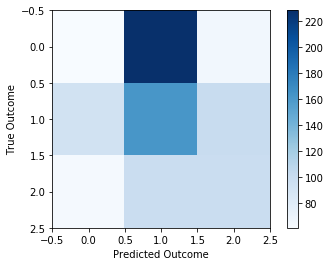

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
#tick_marks = np.arange(len(test.[target))
#plt.xticks(tick_marks, test.target, rotation=45)
#plt.yticks(tick_marks, test.target)
plt.xlabel("Predicted Outcome")
plt.ylabel("True Outcome")
plt.show()

In [28]:
from sklearn. metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.29      0.24      0.26       261
           1       0.47      0.64      0.54       355
           2       0.38      0.28      0.32       356

    accuracy                           0.40       972
   macro avg       0.38      0.39      0.38       972
weighted avg       0.39      0.40      0.39       972

